In [2]:
import scvi
import scanpy as sc
import pandas as pd
import numpy as np

Global seed set to 0


In [3]:
import matplotlib.pyplot as plt

In [4]:
import scanpy.external as sce

In [5]:
import torch
import pickle

In [6]:
import anndata

In [7]:
import h5py

In [8]:
import os

In [9]:
from pyscenic.aucell import aucell
from pyscenic.genesig import GeneSignature
from pyscenic.aucell import create_rankings, enrichment

#### Load data

In [14]:
adata = sc.read('pancreas_normal.h5ad')

/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


#### QC

In [17]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL")) # annotate ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True, qc_vars=['mt', 'ribo'])

In [20]:
adata = adata[adata.obs.total_counts > 300, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata = adata[adata.obs.total_counts < 40000, :]

#### Train model

In [70]:
adata = adata.copy()

In [26]:
scvi.model.SCVI.setup_anndata(adata, batch_key="batch", labels_key='fine_peng_cell_type')

In [27]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=20, gene_likelihood="nb")

In [28]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 205/205: 100%|██████████| 205/205 [14:12<00:00,  4.16s/it, loss=5.18e+03, v_num=1]


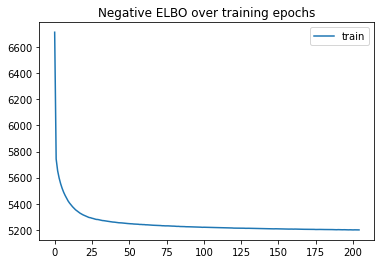

In [30]:
plt.plot(vae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [31]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    unlabeled_category="Unknown",
)

In [32]:
lvae.train(25)

INFO     Training for 25 epochs.                                                                                   


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 25/25: 100%|██████████| 25/25 [03:33<00:00,  8.53s/it, loss=5.27e+03, v_num=1]


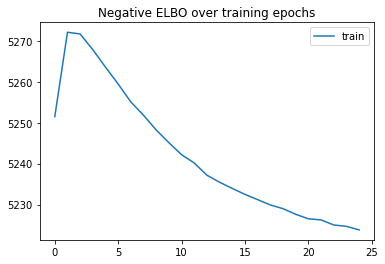

In [33]:
plt.plot(lvae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [34]:
adata.obsm["X_scVI"] = vae.get_latent_representation(adata)

In [35]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

In [36]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

In [37]:
sc.tl.leiden(adata)

In [42]:
lvae.save('pancreas_normal_tissue_scanvi', overwrite=True)

In [43]:
adata.obs["C_scANVI"] = lvae.predict(adata)

In [44]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

In [45]:
sc.tl.leiden(adata, resolution=0.1)

In [73]:
adata_immune = adata[adata.obs['leiden'].isin(['0', '3', '5', '8', '10', '13'])].copy()

In [75]:
import celltypist

In [76]:
adata_celltypist = adata_immune.copy()

In [77]:
sc.pp.normalize_total(adata_celltypist, target_sum=1e4)
sc.pp.log1p(adata_celltypist)

In [78]:
predictions = celltypist.annotate(adata_celltypist, model = 'Immune_All_Low.pkl', majority_voting = True)

In [79]:
adata_immune.obs['celltypist_prediction'] = predictions.predicted_labels['predicted_labels'][adata_immune.obs.index]#.to_numpy()
adata_immune.obs['celltypist_majority_voting'] = predictions.predicted_labels['majority_voting'][adata_immune.obs.index]#.to_numpy()

In [83]:
adata.obs['level2_cell_type'] = [x if not y in adata_immune.obs.index else adata_immune.obs['celltypist_majority_voting'][y] for x,y in zip(adata.obs['C_scANVI'], adata.obs.index)]

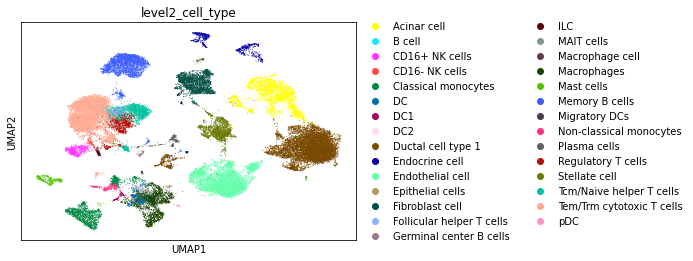

In [16]:
sc.pl.umap(adata, color='level2_cell_type')#, save='normal_pancreas_cell_types.pdf')